In [1]:
import numpy as np
from skimage import io
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
import src.plots

In [170]:
plt.rcParams.update({'font.size': 16})

In [2]:
!ls data

sat.trn sat.tst


In [3]:
train, test = np.loadtxt('data/sat.trn'), np.loadtxt('data/sat.tst')

In [4]:
train

array([[ 92., 115., 120., ..., 113.,  87.,   3.],
       [ 84., 102., 106., ..., 104.,  79.,   3.],
       [ 84., 102., 102., ..., 104.,  79.,   3.],
       ...,
       [ 68.,  75., 108., ..., 104.,  85.,   4.],
       [ 71.,  87., 108., ..., 104.,  85.,   4.],
       [ 71.,  91., 100., ..., 100.,  81.,   4.]])

In [5]:
test

array([[ 80., 102., 102., ..., 113.,  87.,   3.],
       [ 76., 102., 102., ..., 104.,  83.,   3.],
       [ 80.,  98., 106., ...,  96.,  75.,   4.],
       ...,
       [ 56.,  68.,  91., ...,  92.,  74.,   5.],
       [ 56.,  68.,  87., ...,  92.,  70.,   5.],
       [ 60.,  71.,  91., ..., 108.,  92.,   5.]])

In [6]:
print(train.shape, test.shape)

(4435, 37) (2000, 37)


In [124]:
# Separate labels into different vectors
y_train, y_test = train[:,-1].astype('int'), test[:,-1].astype('int')

In [125]:
y_train, y_test

(array([3, 3, 3, ..., 4, 4, 4]), array([3, 3, 4, ..., 5, 5, 5]))

In [126]:
print(len(y_train), len(y_test))

4435 2000


In [127]:
# Separate 3x3x4 pixel neighborhood samples into train and test feature samples
X_train, X_test = train[:,:-1], test[:,:-1]

In [128]:
X_train

array([[ 92., 115., 120., ..., 107., 113.,  87.],
       [ 84., 102., 106., ...,  99., 104.,  79.],
       [ 84., 102., 102., ...,  99., 104.,  79.],
       ...,
       [ 68.,  75., 108., ..., 100., 104.,  85.],
       [ 71.,  87., 108., ...,  91., 104.,  85.],
       [ 71.,  91., 100., ...,  91., 100.,  81.]])

## Exploratory Data Analysis

In [129]:
# Determine class count for each label in training set
def class_counts(y):
    labels, labels_inverse, label_counts = np.unique(y, return_inverse=True, return_counts=True)
    return labels, labels_inverse, label_counts

In [130]:
labels, labels_inverse, label_counts = class_counts(y_train)

<ipython-input-131-8ded52a36041>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','1 - red soil', '2 - cotton crop', '3 - grey soil', '4 - damp grey soil', '5 - soil w/veg.', '6 - mixture', '7 - very damp grey soil'], rotation=45);


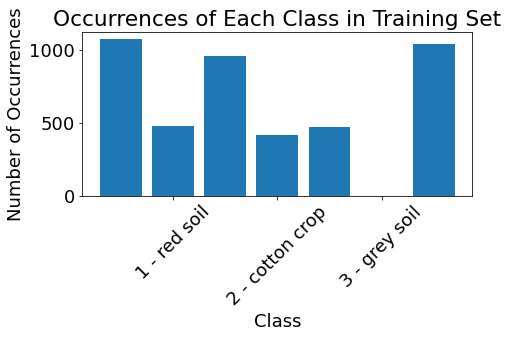

In [131]:
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(labels, label_counts)
ax.set_xlabel('Class')
ax.set_ylabel('Number of Occurrences')
ax.set_title('Occurrences of Each Class in Training Set')
ax.set_xticklabels(['','1 - red soil', '2 - cotton crop', '3 - grey soil', '4 - damp grey soil', '5 - soil w/veg.', '6 - mixture', '7 - very damp grey soil'], rotation=45);

plt.tight_layout()
#plt.savefig('imgs/train_class_count.png')

In [132]:
# Calculate and plot mean spectral signature for each class
means = []
for idx,label in enumerate(labels):
    means.append(np.mean(X_train[labels_inverse==idx,16:20], axis=0))
# 

In [133]:
means

[array([ 62.8255597 ,  95.29384328, 108.12313433,  88.60074627]),
 array([ 48.83924843,  39.91440501, 113.88935282, 118.31106472]),
 array([ 87.47866805, 105.49843913, 110.5962539 ,  87.45681582]),
 array([77.40963855, 90.94457831, 95.61445783, 75.35421687]),
 array([59.5893617 , 62.26595745, 83.02340426, 69.95319149]),
 array([69.01252408, 77.42196532, 81.59248555, 64.12524085])]

In [17]:
# Calculate cosine similarity of mean vectors

In [18]:
# 3D Histogram of Pixel Neighborhood?

In [19]:
# Plot Average intensity for neighborhood across each band

In [20]:
# Scatter plot of mean vectors for each class

## Sanity Check

In [21]:
X_train[0,:]

array([ 92., 115., 120.,  94.,  84., 102., 106.,  79.,  84., 102., 102.,
        83., 101., 126., 133., 103.,  92., 112., 118.,  85.,  84., 103.,
       104.,  81., 102., 126., 134., 104.,  88., 121., 128., 100.,  84.,
       107., 113.,  87.])

In [22]:
X_train[0,16:20]

array([ 92., 112., 118.,  85.])

In [23]:
train[0,:]

array([ 92., 115., 120.,  94.,  84., 102., 106.,  79.,  84., 102., 102.,
        83., 101., 126., 133., 103.,  92., 112., 118.,  85.,  84., 103.,
       104.,  81., 102., 126., 134., 104.,  88., 121., 128., 100.,  84.,
       107., 113.,  87.,   3.])

## Baseline Model

In [134]:
# Classify each sample by closest distance to mean vector
mean_dict = {label: means[i] for i,label in enumerate(labels)} # Create dictionary of mean spectral vector per class label

In [135]:
mean_dict 

{1: array([ 62.8255597 ,  95.29384328, 108.12313433,  88.60074627]),
 2: array([ 48.83924843,  39.91440501, 113.88935282, 118.31106472]),
 3: array([ 87.47866805, 105.49843913, 110.5962539 ,  87.45681582]),
 4: array([77.40963855, 90.94457831, 95.61445783, 75.35421687]),
 5: array([59.5893617 , 62.26595745, 83.02340426, 69.95319149]),
 7: array([69.01252408, 77.42196532, 81.59248555, 64.12524085])}

In [136]:
def euclidean_distance(a,b):
    return np.sqrt(sum((a-b)**2))

In [137]:
euclidean_distance(train[-1,16:20], mean_dict[3.0])

24.776905414321906

In [138]:
def min_distance_classifier(X, mean_dict,labels):
    predicts = []
    label_dict = {num:label for num,label in zip(np.arange(len(labels)), labels)}
    for sample in X[:,16:20]:
        mean_index = np.argmin([euclidean_distance(sample, mean_vector) for mean_vector in mean_dict.values()])
        predicts.append(label_dict[mean_index])
    return np.array(predicts)

In [139]:
y_predict = min_distance_classifier(X_train, mean_dict, labels)

In [140]:
y_predict

array([3, 3, 4, ..., 4, 4, 4])

In [141]:
np.count_nonzero(y_predict == y_train)/len(X_train)

0.7641488162344983

In [152]:
print(f'Baseline Model Accuracy: {accuracy_score(y_train,y_predict)}') # Baseline model accuracy

Baseline Model Accuracy: 0.7641488162344983


In [142]:
y_test_predict = min_distance_classifier(X_test, mean_dict, labels)

In [143]:
np.count_nonzero(y_test_predict == y_test)/len(X_test)

0.7685

In [144]:
y_test_predict

array([3, 3, 4, ..., 5, 7, 1])

In [145]:
y_test

array([3, 3, 4, ..., 5, 5, 5])

## Neural Network

In [155]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical

In [156]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

enc.fit(y_train.reshape(-1,1))

y_trn_1hot = enc.transform(y_train.reshape(-1,1)).toarray()


In [157]:
# Scale the training data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_trn_scaled = scaler.transform(X_train)


In [158]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
hidden_units = 100
n_classes = 6

In [159]:
def create_model(X, n_classes, opt='Adam', hidden_units=100, drop_out=0, activ='softsign'):
    np.random.seed(42)

    n_samples, n_feats = X.shape

    model = Sequential() # sequence of layers

    hidden_layer = Dense(units=hidden_units,
                    input_dim=n_feats,
                    kernel_initializer='constant',
                    activation=activ)

    hidden_layer_2 = Dense(units=hidden_units,
                    kernel_initializer='constant',
                    activation=activ)

    outputlayer = Dense(units=n_classes,
                    input_dim=hidden_units,
                    kernel_initializer='uniform',
                    activation='softmax')

    model.add(hidden_layer)
    model.add(Dropout(drop_out))
    model.add(hidden_layer_2)
    model.add(Dropout(drop_out))
    model.add(hidden_layer_2)
    model.add(Dropout(drop_out))
    model.add(outputlayer)

    model.compile(loss='categorical_crossentropy', 
                  optimizer=opt, metrics=["accuracy"])
    return model

In [160]:
model = create_model(X_trn_scaled, n_classes, opt)

In [161]:
history = model.fit(X_trn_scaled, y_trn_1hot, epochs=350, batch_size=50, verbose=1, validation_split=0)


Epoch 1/350
89/89 [==============================] - 0s 996us/step - loss: 1.6796 - accuracy: 0.2589
Epoch 2/350
89/89 [==============================] - 0s 952us/step - loss: 1.3489 - accuracy: 0.3425
Epoch 3/350
89/89 [==============================] - 0s 1ms/step - loss: 1.2779 - accuracy: 0.4354
Epoch 4/350
89/89 [==============================] - 0s 1ms/step - loss: 1.0593 - accuracy: 0.5729
Epoch 5/350
89/89 [==============================] - 0s 997us/step - loss: 0.8888 - accuracy: 0.6365
Epoch 6/350
89/89 [==============================] - 0s 1ms/step - loss: 0.8139 - accuracy: 0.6882
Epoch 7/350
89/89 [==============================] - 0s 1ms/step - loss: 0.6991 - accuracy: 0.7741
Epoch 8/350
89/89 [==============================] - 0s 1ms/step - loss: 0.6168 - accuracy: 0.7923
Epoch 9/350
89/89 [==============================] - 0s 1ms/step - loss: 0.5875 - accuracy: 0.7928
Epoch 10/350
89/89 [==============================] - 0s 1ms/step - loss: 0.5537 - accuracy: 0.8032
Epo

89/89 [==============================] - 0s 946us/step - loss: 0.3099 - accuracy: 0.8798
Epoch 83/350
89/89 [==============================] - 0s 900us/step - loss: 0.3039 - accuracy: 0.8773
Epoch 84/350
89/89 [==============================] - 0s 975us/step - loss: 0.3012 - accuracy: 0.8773
Epoch 85/350
89/89 [==============================] - 0s 955us/step - loss: 0.3064 - accuracy: 0.8776
Epoch 86/350
89/89 [==============================] - 0s 933us/step - loss: 0.2977 - accuracy: 0.8803
Epoch 87/350
89/89 [==============================] - 0s 1ms/step - loss: 0.3106 - accuracy: 0.8778
Epoch 88/350
89/89 [==============================] - 0s 955us/step - loss: 0.2962 - accuracy: 0.8776
Epoch 89/350
89/89 [==============================] - 0s 951us/step - loss: 0.2994 - accuracy: 0.8812
Epoch 90/350
89/89 [==============================] - 0s 972us/step - loss: 0.2983 - accuracy: 0.8809
Epoch 91/350
89/89 [==============================] - 0s 966us/step - loss: 0.3000 - accuracy: 0.

Epoch 163/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2559 - accuracy: 0.8983
Epoch 164/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2620 - accuracy: 0.8976
Epoch 165/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2561 - accuracy: 0.8949
Epoch 166/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2534 - accuracy: 0.9006
Epoch 167/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2558 - accuracy: 0.8979
Epoch 168/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2659 - accuracy: 0.8943
Epoch 169/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2513 - accuracy: 0.8990
Epoch 170/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2564 - accuracy: 0.8992
Epoch 171/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2531 - accuracy: 0.8967
Epoch 172/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2613 - accurac

89/89 [==============================] - 0s 1ms/step - loss: 0.2158 - accuracy: 0.9166
Epoch 245/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2175 - accuracy: 0.9134
Epoch 246/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2156 - accuracy: 0.9154
Epoch 247/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2167 - accuracy: 0.9143
Epoch 248/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2156 - accuracy: 0.9168
Epoch 249/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2176 - accuracy: 0.9195
Epoch 250/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2100 - accuracy: 0.9188
Epoch 251/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2172 - accuracy: 0.9168
Epoch 252/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2167 - accuracy: 0.9154
Epoch 253/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2111 - accuracy: 0.9168
Epoc

89/89 [==============================] - 0s 829us/step - loss: 0.1873 - accuracy: 0.9265
Epoch 325/350
89/89 [==============================] - 0s 944us/step - loss: 0.1898 - accuracy: 0.9256
Epoch 326/350
89/89 [==============================] - 0s 964us/step - loss: 0.1933 - accuracy: 0.9245
Epoch 327/350
89/89 [==============================] - 0s 982us/step - loss: 0.1921 - accuracy: 0.9249
Epoch 328/350
89/89 [==============================] - 0s 872us/step - loss: 0.1866 - accuracy: 0.9236
Epoch 329/350
89/89 [==============================] - 0s 937us/step - loss: 0.1817 - accuracy: 0.9278
Epoch 330/350
89/89 [==============================] - 0s 970us/step - loss: 0.1852 - accuracy: 0.9263
Epoch 331/350
89/89 [==============================] - 0s 960us/step - loss: 0.1854 - accuracy: 0.9260
Epoch 332/350
89/89 [==============================] - 0s 982us/step - loss: 0.1851 - accuracy: 0.9249
Epoch 333/350
89/89 [==============================] - 0s 1ms/step - loss: 0.1843 - acc

In [162]:
history.history

{'loss': [1.6796047687530518,
  1.3488812446594238,
  1.277948260307312,
  1.0593231916427612,
  0.8888261914253235,
  0.8139194250106812,
  0.6991119980812073,
  0.6168006658554077,
  0.5874670147895813,
  0.5537123084068298,
  0.5374277234077454,
  0.5180270075798035,
  0.4905589818954468,
  0.4583840072154999,
  0.4239805042743683,
  0.4157748818397522,
  0.3977782130241394,
  0.3935543894767761,
  0.3858940303325653,
  0.3706521689891815,
  0.36545881628990173,
  0.36601099371910095,
  0.36601150035858154,
  0.35608112812042236,
  0.35349026322364807,
  0.3568333685398102,
  0.34893798828125,
  0.35087162256240845,
  0.3425719141960144,
  0.35499849915504456,
  0.3413953185081482,
  0.3422822654247284,
  0.3417712152004242,
  0.3354267477989197,
  0.3334783613681793,
  0.3392886817455292,
  0.3324145972728729,
  0.33199015259742737,
  0.3264031708240509,
  0.3290932774543762,
  0.328071653842926,
  0.32386675477027893,
  0.32218775153160095,
  0.3215583264827728,
  0.32592469453811

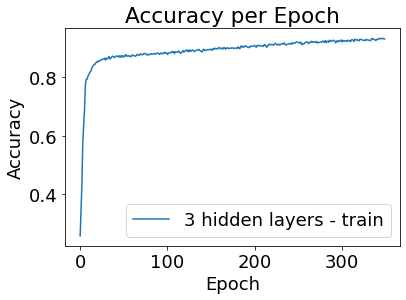

In [163]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['accuracy'], label = '3 hidden layers - train')
#ax.plot(history.epoch, history.history['val_accuracy'], label = '3 hidden layers - val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per Epoch')
ax.legend()

In [164]:
model.evaluate(scaler.transform(X_test), enc.transform(y_test.reshape(-1,1)).toarray())  # Calculate performance metrics on unseen test data

63/63 [==============================] - 0s 670us/step - loss: 0.2641 - accuracy: 0.8990


[0.264081209897995, 0.8989999890327454]

### Decision Tree Classifier

In [146]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)
yhat_trn = clf_dt.predict(X_train)
print(accuracy_score(y_train, yhat_trn))
yhat = clf_dt.predict(X_test)
print(accuracy_score(y_test, yhat))

1.0
0.8525


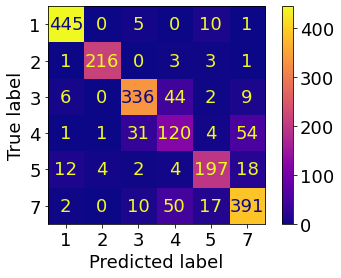

In [147]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix
conf_mx = confusion_matrix(y_test, yhat, labels=clf_dt.classes_)
np.round(conf_mx, 2)
cm_display = ConfusionMatrixDisplay(conf_mx, display_labels=clf_dt.classes_).plot(cmap='plasma')

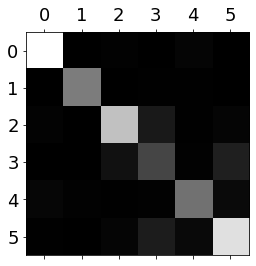

In [148]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [149]:
clf_dt.classes_

array([1, 2, 3, 4, 5, 7])

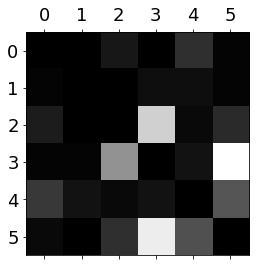

In [150]:
np.fill_diagonal(conf_mx, 0)
plt.matshow(conf_mx, cmap=plt.cm.gray)

### Random Forest Classifier

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)
y_trn_rf = clf.predict(X_train)
print(f'Train Accuracy: {accuracy_score(y_train, y_trn_rf)}')
y_rf = clf.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test, y_rf)}')

Train Accuracy: 1.0
Test Accuracy: 0.907


## Grid Search

### Neural Network Search

In [54]:
modelo = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, X=X_trn_scaled, n_classes=6, opt=opt)

In [55]:
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid']

In [56]:
# Set grid search parameters
param_grid = dict(epochs=[350, 400], batch_size=[40], drop_out = [0,0.05,0.1], activ=activation)
grid = GridSearchCV(estimator=modelo, param_grid=param_grid, n_jobs=-1, cv=[(slice(None), slice(None))])
grid_result = grid.fit(X_trn_scaled, y_trn_1hot)

Epoch 1/350
111/111 [==============================] - 0s 1ms/step - loss: 1.2454 - accuracy: 0.4449
Epoch 2/350
111/111 [==============================] - 0s 2ms/step - loss: 0.8743 - accuracy: 0.6710
Epoch 3/350
111/111 [==============================] - 0s 2ms/step - loss: 0.6104 - accuracy: 0.8065
Epoch 4/350
111/111 [==============================] - 0s 1ms/step - loss: 0.5016 - accuracy: 0.8158
Epoch 5/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4446 - accuracy: 0.8361
Epoch 6/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4164 - accuracy: 0.8440
Epoch 7/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4111 - accuracy: 0.8480
Epoch 8/350
111/111 [==============================] - 0s 1ms/step - loss: 0.4006 - accuracy: 0.8539
Epoch 9/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3974 - accuracy: 0.8564
Epoch 10/350
111/111 [==============================] - 0s 1ms/step - loss: 0.3958 - accura

111/111 [==============================] - 0s 1ms/step - loss: 0.2962 - accuracy: 0.8767
Epoch 82/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2955 - accuracy: 0.8828
Epoch 83/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2992 - accuracy: 0.8769
Epoch 84/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2929 - accuracy: 0.8821
Epoch 85/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2880 - accuracy: 0.8859
Epoch 86/350
111/111 [==============================] - 0s 2ms/step - loss: 0.2954 - accuracy: 0.8812
Epoch 87/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2896 - accuracy: 0.8807
Epoch 88/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2923 - accuracy: 0.8821
Epoch 89/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2927 - accuracy: 0.8832
Epoch 90/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2920 - accuracy: 

111/111 [==============================] - 0s 1ms/step - loss: 0.2416 - accuracy: 0.9039
Epoch 161/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2364 - accuracy: 0.9062
Epoch 162/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2359 - accuracy: 0.9048
Epoch 163/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2368 - accuracy: 0.9073
Epoch 164/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2472 - accuracy: 0.9044
Epoch 165/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2332 - accuracy: 0.9091
Epoch 166/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2395 - accuracy: 0.9051
Epoch 167/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2354 - accuracy: 0.9089
Epoch 168/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2378 - accuracy: 0.9085
Epoch 169/350
111/111 [==============================] - 0s 1ms/step - loss: 0.2371 - a

111/111 [==============================] - 0s 1ms/step - loss: 0.1941 - accuracy: 0.9215
Epoch 240/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1901 - accuracy: 0.9258
Epoch 241/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1913 - accuracy: 0.9251
Epoch 242/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1869 - accuracy: 0.9256
Epoch 243/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1916 - accuracy: 0.9254
Epoch 244/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1929 - accuracy: 0.9211
Epoch 245/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1889 - accuracy: 0.9238
Epoch 246/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1860 - accuracy: 0.9272
Epoch 247/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1893 - accuracy: 0.9274
Epoch 248/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1847 - a

111/111 [==============================] - 0s 1ms/step - loss: 0.1562 - accuracy: 0.9396
Epoch 319/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1566 - accuracy: 0.9371
Epoch 320/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1579 - accuracy: 0.9380
Epoch 321/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1493 - accuracy: 0.9436
Epoch 322/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1541 - accuracy: 0.9409
Epoch 323/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1497 - accuracy: 0.9425
Epoch 324/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1510 - accuracy: 0.9391
Epoch 325/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1510 - accuracy: 0.9411
Epoch 326/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1485 - accuracy: 0.9409
Epoch 327/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1558 - a

In [57]:
grid_result.best_params_

{'activ': 'tanh', 'batch_size': 40, 'drop_out': 0, 'epochs': 350}

In [58]:
grid_result.best_score_

0.9519729614257812

In [59]:
np.mean(grid_result.best_estimator_.model.history.history['accuracy']), max(grid_result.best_estimator_.model.history.history['accuracy'])

(0.9034208399908883, 0.9481397867202759)

In [60]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.951973 using {'activ': 'tanh', 'batch_size': 40, 'drop_out': 0, 'epochs': 350}


In [224]:
grid_result.best_estimator_.model.evaluate(scaler.transform(X_test), enc.transform(y_test.reshape(-1,1)).toarray())

63/63 [==============================] - 0s 840us/step - loss: 0.2899 - accuracy: 0.8990


[0.28992483019828796, 0.8989999890327454]

In [62]:
grid_result.cv_results_

{'mean_fit_time': array([ 83.01147008, 143.00132108,  81.89280295,  92.9061389 ,
         72.72720623,  85.22190189,  82.66594601,  86.72836089,
         78.33812881,  89.11057997,  80.23653817,  87.7717104 ,
         83.23592186,  83.03136516,  74.01980519,  88.02119088,
         78.76311874, 143.12847018,  75.16310382,  83.24721789,
         83.39000392,  83.47687292,  82.53406501, 142.79275799,
         83.21040297,  82.83960772,  83.47526813,  78.3371799 ,
         68.40074897,  86.68529105,  73.56881595,  82.26756215,
         78.00509596,  83.5165379 ,  84.59330988,  68.72735405]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 'mean_score_time': array([0.29698396, 0.57054496, 0.51592422, 0.56784797, 0.60629988,
        0.38796306, 0.33377171, 0.63487387, 0.75552917, 0.57087493,
        0.56777287, 0.58393073, 0.35598588, 0.36933684, 0.536713

In [63]:
grid_result.best_estimator_.classes_= np.array([1,2,3,4,5,7])

In [64]:
yhat_nn= grid_result.best_estimator_.predict(scaler.transform(X_test))

/Users/jordyns/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


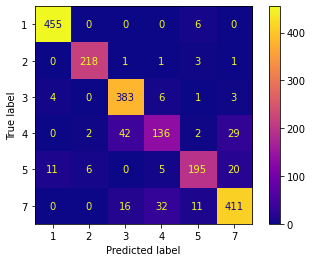

In [68]:
# Confusion Matrix for Neural Network
plot_cm(y_test, yhat_nn, grid_result.best_estimator_)

In [223]:
def plot_cm(y_test, yhat, classes, ax=None):
    # Confusion Matrix
    conf_mx = confusion_matrix(y_test, yhat, labels=classes)
    cm_display = ConfusionMatrixDisplay(conf_mx, display_labels=classes).plot(cmap='plasma', ax=ax)

### Random Forest Search

In [165]:
rf_param_grid = dict(n_estimators=[10, 50, 100, 150, 200], min_samples_split=np.arange(2,10,2),
    min_samples_leaf=np.arange(1,10,2), max_depth = np.arange(10,100,10),
    class_weight=['balanced', 'balanced_subsample'])
grid = GridSearchCV(estimator=clf, param_grid=rf_param_grid, n_jobs=-1, cv=5,scoring='f1_weighted')
rf_grid_result = grid.fit(X_train, y_train)

In [166]:
print(f'Best Estimator Parameters: {rf_grid_result.best_params_}\n')
print(f'Average Validation Accuracy: {rf_grid_result.best_score_}')

Best Estimator Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}

Average Validation Accuracy: 0.8578329737600962


In [167]:
y_rf = rf_grid_result.best_estimator_.predict(X_test)
score = f1_score(y_test, y_rf, average='weighted')
print(f'Test F1 Score: {score}\n')
print(f'Test Accuracy Score: {accuracy_score(y_test, y_rf)}')

Test F1 Score: 0.9060716474623401

Test Accuracy Score: 0.907


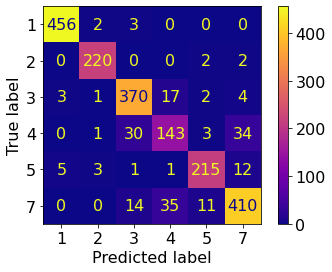

In [171]:
plot_cm(y_test, y_rf, rf_grid_result.best_estimator_.classes_)

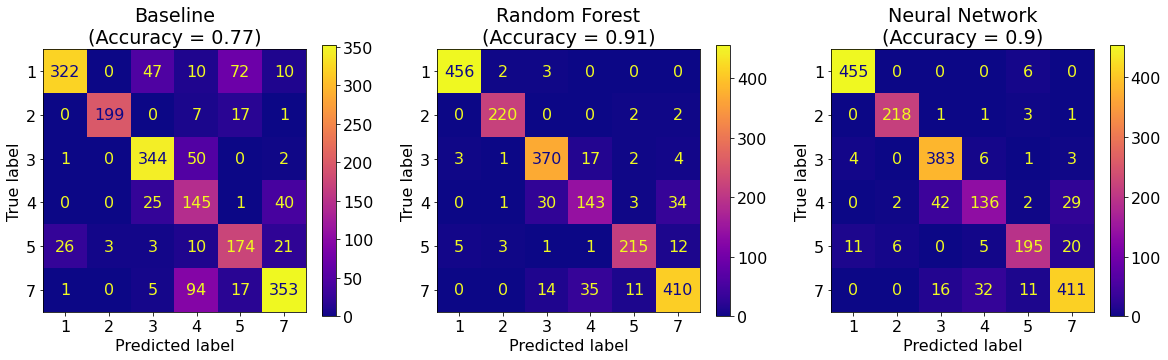

In [173]:
# Compare confusion matrices
fig, axs = plt.subplots(1,3,figsize=(20,5))
plot_cm(y_test, y_test_predict, labels, axs[0])
plot_cm(y_test, y_rf, rf_grid_result.best_estimator_.classes_, axs[1])
plot_cm(y_test, yhat_nn, grid_result.best_estimator_.classes_, axs[2])
axs[0].set_title(f'Baseline\n(Accuracy = {np.round(accuracy_score(y_test, y_test_predict),2)})')
axs[1].set_title(f'Random Forest\n(Accuracy = {np.round(accuracy_score(y_test, y_rf),2)})')
axs[2].set_title(f'Neural Network\n(Accuracy = {np.round(accuracy_score(y_test, yhat_nn),2)})')
#plt.savefig('imgs/confusion_matrices.png')

In [92]:
print(f1_score(y_test, y_rf, average='weighted'), f1_score(y_test, yhat_nn, average='weighted'))

0.8991006349848841 0.8968280126959071
